<a href="https://colab.research.google.com/github/Junior-sls/Trabalho_AlgoritimosEvolucionarios/blob/main/mainsimulation(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

otimização BIOMA FÁCIL (Muita Planície)...
otimização BIOMA DIFÍCIL (Muita Montanha)...


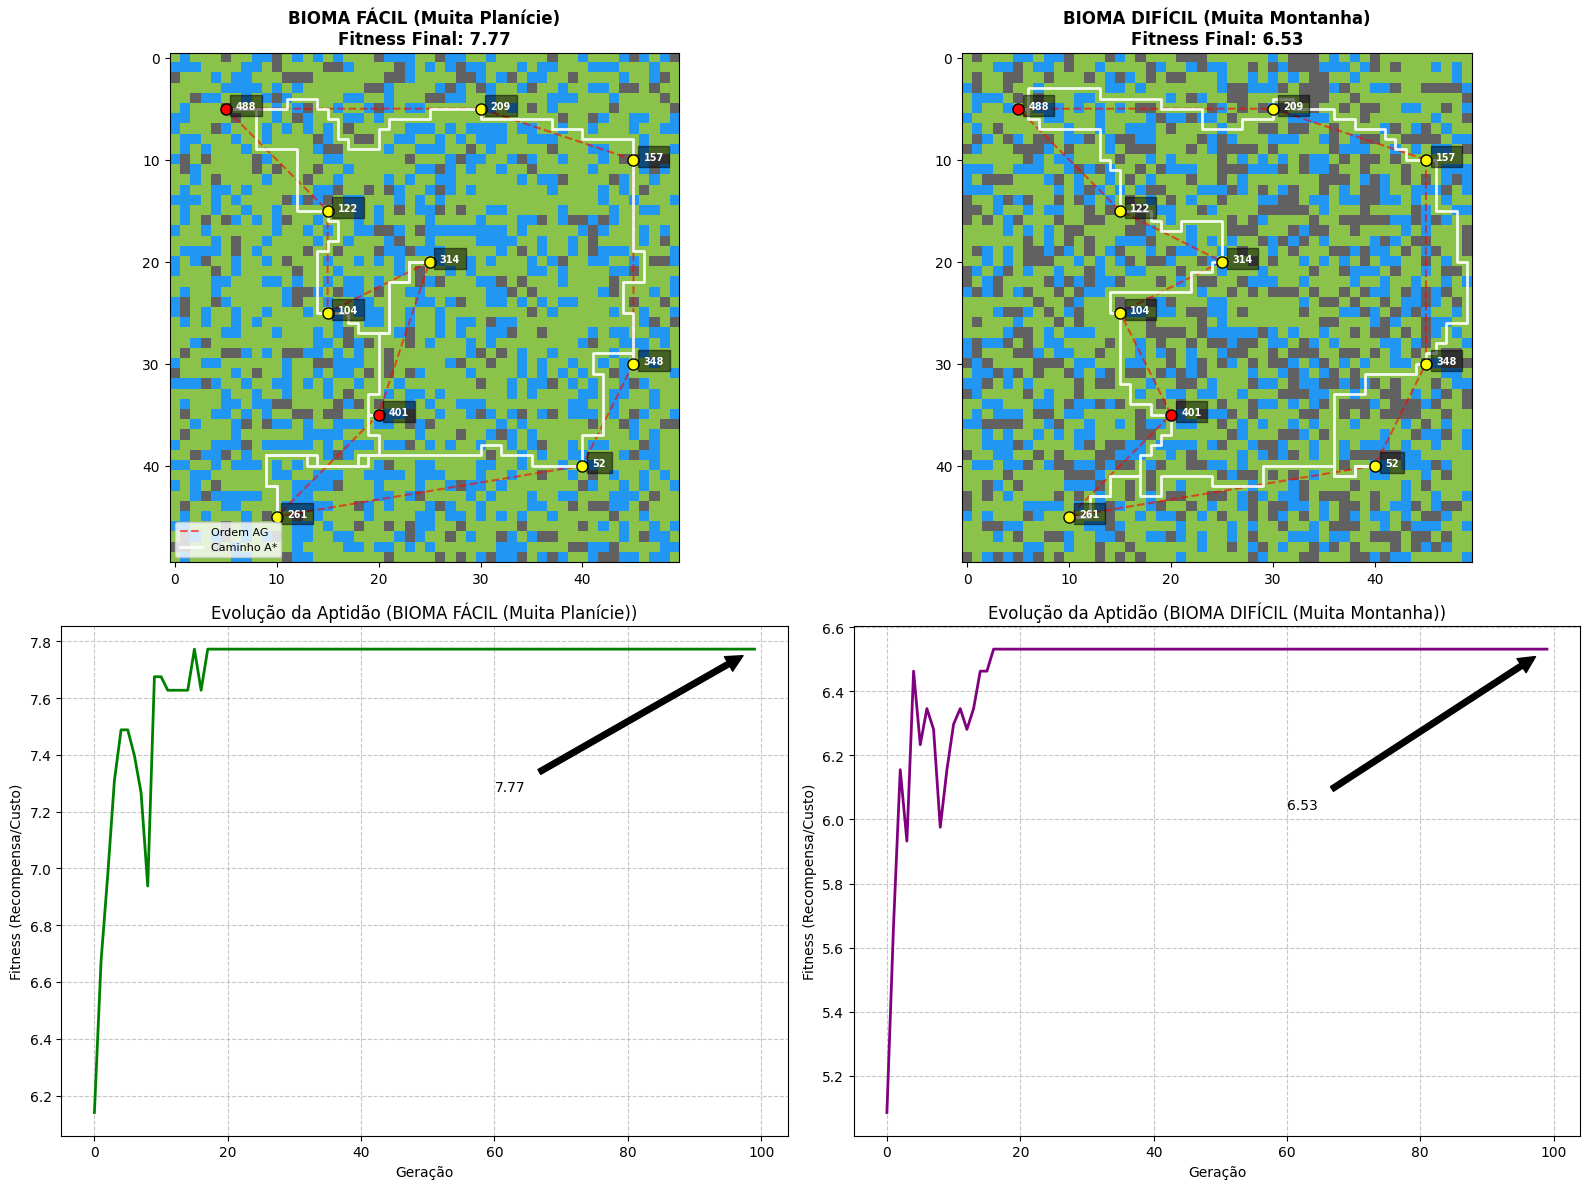

Rota Otimizada (Ordem): O3 -> O4 -> O7 -> O2 -> O0 -> O8 -> O5 -> O6 -> O1 -> O9
| Métrica                   | Valor                |
| Fitness Final             | 5.6852               |
| Custo Total (Tempo)       | 432.00               |
| Recompensa Total          | 2456                 |


In [22]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def reconstruct_path(came_from, current):
    path = [current]
    while came_from.get(current) is not None:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def calcular_custo_a_estrela(grid, start_point, end_point, TERRAIN_COSTS):
    rows, cols = grid.shape
    priority_queue = [(0, 0, start_point)]
    g_score = { (r, c): float('inf') for r in range(rows) for c in range(cols) }
    g_score[start_point] = 0
    came_from = {}
    came_from[start_point] = None
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    while priority_queue:
        f_score, current_g, current_point = heapq.heappop(priority_queue)
        if current_point == end_point:
            path = reconstruct_path(came_from, end_point)
            return current_g, path
        r, c = current_point
        for dr, dc in neighbors:
            next_r, next_c = r + dr, c + dc
            next_point = (next_r, next_c)
            if 0 <= next_r < rows and 0 <= next_c < cols:
                terrain_type = grid[next_r, next_c]
                move_cost = TERRAIN_COSTS.get(terrain_type, 1)
                new_g_score = current_g + move_cost
                if new_g_score < g_score[next_point]:
                    g_score[next_point] = new_g_score
                    came_from[next_point] = current_point
                    h_score = manhattan_distance(next_point, end_point)
                    f_score = new_g_score + h_score
                    heapq.heappush(priority_queue, (f_score, new_g_score, next_point))
    return float('inf'), []

class GeneticAlgorithmTSP:
    def __init__(self, outbreak_points, costs_matrix, rewards_list, population_size=150, generations=100):
        self.points = outbreak_points
        self.num_points = len(outbreak_points)
        self.costs_matrix = costs_matrix
        self.rewards_list = rewards_list
        self.POP_SIZE = population_size
        self.GENERATIONS = generations
        self.population = self._initialize_population()
        self.best_route = None
        self.best_fitness = -float('inf')
        self.history = []

    def _initialize_population(self):
        population = []
        base_route = list(range(self.num_points))
        for _ in range(self.POP_SIZE):
            route = base_route[:]
            random.shuffle(route)
            population.append(route)
        return population

    def _calculate_fitness(self, route):
        total_cost = 0
        total_reward = 0
        for i in range(self.num_points):
            start_index = route[i]
            end_index = route[(i + 1) % self.num_points]
            total_cost += self.costs_matrix[start_index, end_index]
        for index in route:
            total_reward += self.rewards_list[index]
        if total_cost == 0: return 0
        return total_reward / total_cost

    def _selection(self, population_fitness):
        pool = random.sample(list(enumerate(population_fitness)), 3)
        best_index = max(pool, key=lambda x: x[1])[0]
        return self.population[best_index]

    def _crossover_order(self, parent1, parent2):
        size = len(parent1)
        a, b = random.sample(range(size), 2)
        start, end = min(a, b), max(a, b)
        child1 = [None] * size
        child2 = [None] * size
        child1[start:end] = parent1[start:end]
        child2[start:end] = parent2[start:end]
        def fill_gaps(child, parent):
            fill_values = [item for item in parent if item not in child]
            fill_idx = 0
            for i in range(size):
                if child[i] is None:
                    child[i] = fill_values[fill_idx]
                    fill_idx += 1
            return child
        return fill_gaps(child1, parent2), fill_gaps(child2, parent1)

    def _mutation(self, route, mutation_rate=0.05):
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(self.num_points), 2)
            route[idx1], route[idx2] = route[idx2], route[idx1]
        return route

    def run(self):
        for generation in range(self.GENERATIONS):
            population_fitness = [self._calculate_fitness(route) for route in self.population]
            max_fitness = max(population_fitness)
            if max_fitness > self.best_fitness:
                self.best_fitness = max_fitness
                self.best_route = self.population[population_fitness.index(max_fitness)]

            self.history.append(max_fitness)

            new_population = []
            while len(new_population) < self.POP_SIZE:
                parent1 = self._selection(population_fitness)
                parent2 = self._selection(population_fitness)
                child1, child2 = self._crossover_order(parent1, parent2)
                new_population.append(self._mutation(child1))
                if len(new_population) < self.POP_SIZE:
                    new_population.append(self._mutation(child2))
            self.population = new_population
        return self.best_route, self.best_fitness

GRID_SIZE = 50
TERRAIN_COSTS = {0: 1, 1: 5, 2: 10}
TERRAIN_COLORS = ['#8BC34A', '#2196F3', '#616161']
cmap_terrain = ListedColormap(TERRAIN_COLORS)
TERRAIN_LABELS = {0: 'Planície (1)', 1: 'Água (5)', 2: 'Montanha (10)'}

OUTBREAK_POINTS = [(5, 5), (10, 45), (25, 15), (40, 40), (45, 10), (20, 25), (5, 30), (35, 20), (15, 15), (30, 45)]
REWARDS = [488, 157, 104, 52, 261, 314, 209, 401, 122, 348]
NUM_OUTBREAKS = len(OUTBREAK_POINTS)


scenarios = [
    { "name": "BIOMA FÁCIL (Muita Planície)", "probs": [0.6, 0.3, 0.1], "color": "green" },
    { "name": "BIOMA DIFÍCIL (Muita Montanha)", "probs": [0.5, 0.25, 0.25], "color": "purple" }
]

results = []


for sc in scenarios:
    print(f"otimização {sc['name']}...")

    grid = np.random.choice([0, 1, 2], size=(GRID_SIZE, GRID_SIZE), p=sc["probs"])

    costs_matrix = np.zeros((NUM_OUTBREAKS, NUM_OUTBREAKS))
    for i in range(NUM_OUTBREAKS):
        for j in range(NUM_OUTBREAKS):
            if i != j:
                c, _ = calcular_custo_a_estrela(grid, OUTBREAK_POINTS[i], OUTBREAK_POINTS[j], TERRAIN_COSTS)
                costs_matrix[i, j] = c

    ag = GeneticAlgorithmTSP(OUTBREAK_POINTS, costs_matrix, REWARDS)
    best_route, fitness = ag.run()

    full_path = []
    total_cost_real = 0
    for i in range(len(best_route)):
        s = OUTBREAK_POINTS[best_route[i]]
        e = OUTBREAK_POINTS[best_route[(i + 1) % NUM_OUTBREAKS]]
        c_segment, segment_path = calcular_custo_a_estrela(grid, s, e, TERRAIN_COSTS)
        total_cost_real += c_segment
        for p in segment_path:
            if not full_path or p != full_path[-1]:
                full_path.append(p)

    results.append({
        "info": sc,
        "grid": grid,
        "history": ag.history,
        "route_idx": best_route,
        "fitness": fitness,
        "full_path": full_path,
        "total_cost": total_cost_real
    })


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, res in enumerate(results):
    ax_map = axes[0, i]
    grid = res['grid']
    name = res['info']['name']
    fit = res['fitness']
    full_path = res['full_path']
    route_idx = res['route_idx']

    ax_map.imshow(grid, cmap=cmap_terrain, origin='upper')
    ax_map.set_title(f"{name}\nFitness Final: {fit:.2f}", fontsize=12, weight='bold')

    tsp_x = [OUTBREAK_POINTS[idx][1] for idx in route_idx] + [OUTBREAK_POINTS[route_idx[0]][1]]
    tsp_y = [OUTBREAK_POINTS[idx][0] for idx in route_idx] + [OUTBREAK_POINTS[route_idx[0]][0]]
    ax_map.plot(tsp_x, tsp_y, 'r--', linewidth=1.5, alpha=0.6, label='Ordem AG')

    path_x = [p[1] for p in full_path]
    path_y = [p[0] for p in full_path]
    ax_map.plot(path_x, path_y, 'w-', linewidth=2.0, alpha=0.9, label='Caminho A*')

    for idx, (r, c) in enumerate(OUTBREAK_POINTS):
        color = 'red' if REWARDS[idx] >= 350 else 'yellow'
        ax_map.plot(c, r, 'o', color=color, markersize=8, markeredgecolor='black', zorder=3)
        ax_map.text(c+1, r, f'{REWARDS[idx]}', color='white', fontsize=7, weight='bold', bbox=dict(facecolor='black', alpha=0.5))

    if i == 0: ax_map.legend(loc='lower left', fontsize=8)

    ax_graph = axes[1, i]
    history = res['history']
    graph_color = res['info']['color']

    ax_graph.plot(history, color=graph_color, linewidth=2)
    ax_graph.set_title(f"Evolução da Aptidão ({name})")
    ax_graph.set_xlabel("Geração")
    ax_graph.set_ylabel("Fitness (Recompensa/Custo)")
    ax_graph.grid(True, linestyle='--', alpha=0.7)

    ax_graph.annotate(f'{history[-1]:.2f}', xy=(len(history)-1, history[-1]), xytext=(len(history)-40, history[-1]-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
print(f"Rota Otimizada (Ordem): {' -> '.join([f'O{i}' for i in best_route_indices])}")
print(f"| {'Métrica':<25} | {'Valor':<20} |")
print(f"| {'Fitness Final':<25} | {max_fitness:<20.4f} |")
print(f"| {'Custo Total (Tempo)':<25} | {current_total_cost:<20.2f} |")
print(f"| {'Recompensa Total':<25} | {sum(REWARDS):<20.0f} |")

cenário BIOMA FÁCIL...
cenário BIOMA DIFÍCIL...


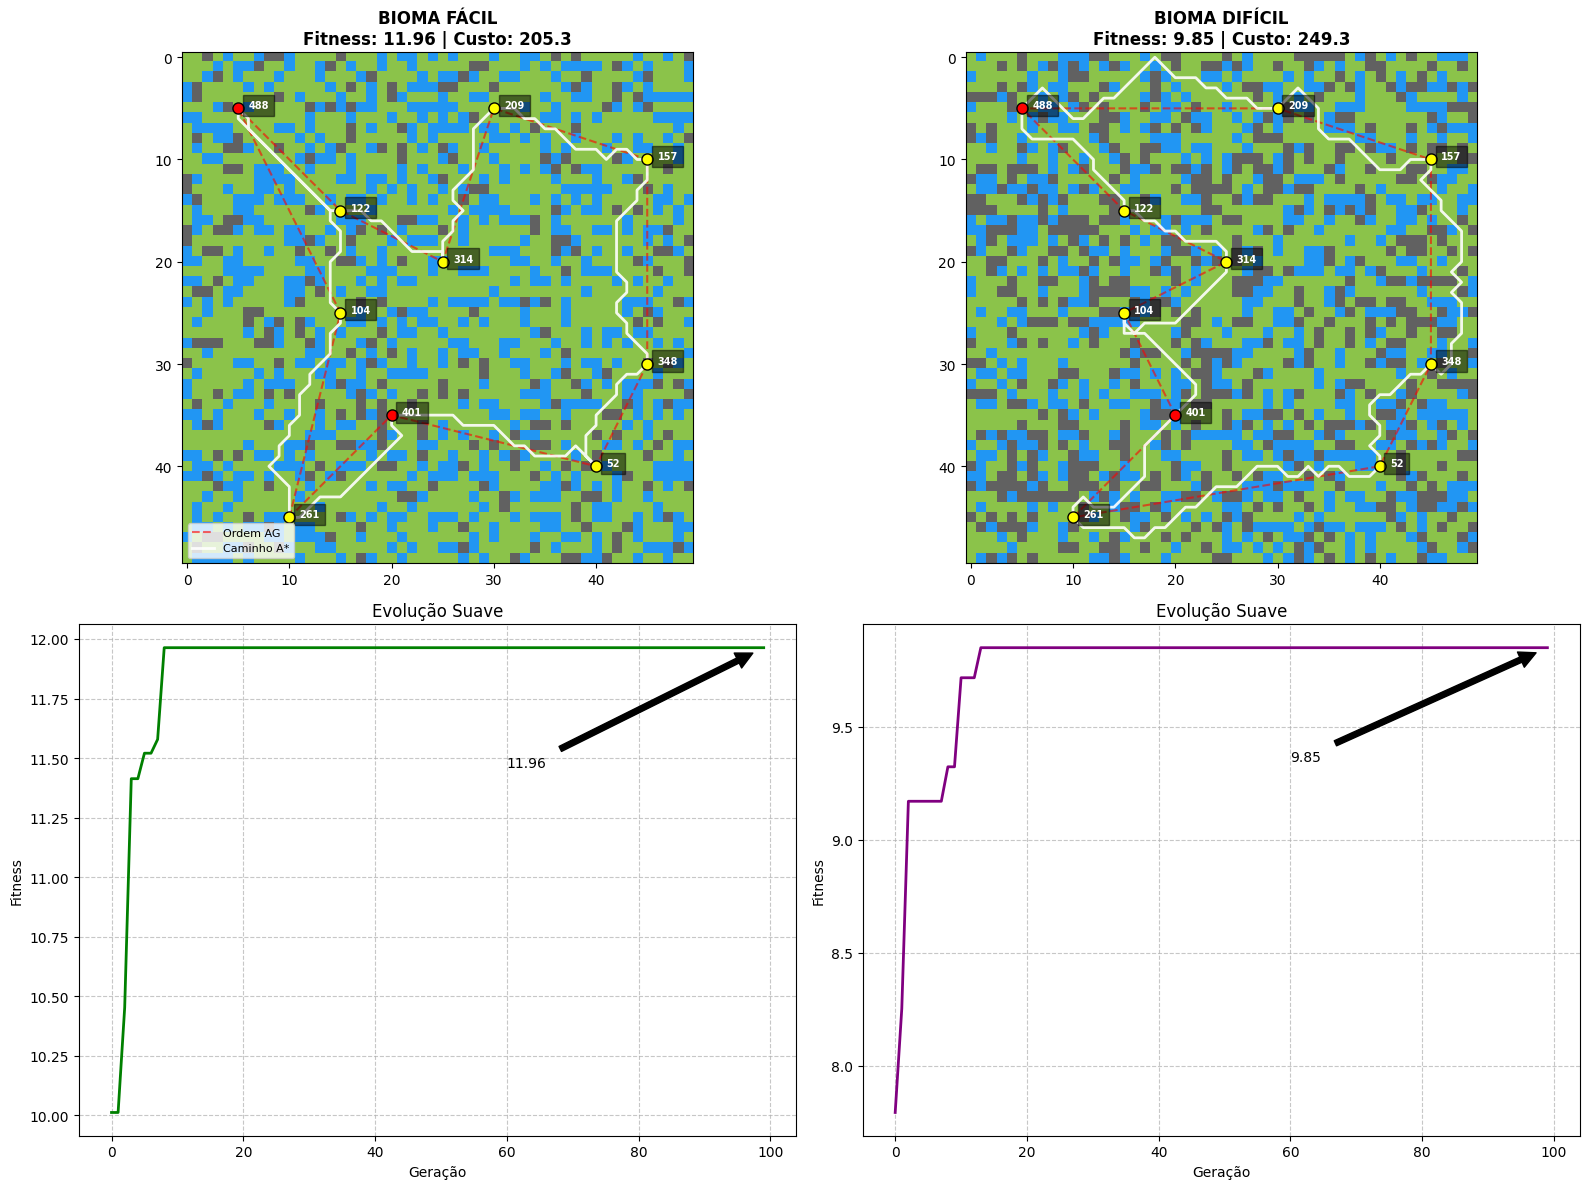

Rota Otimizada (Ordem): O3 -> O4 -> O7 -> O2 -> O0 -> O8 -> O5 -> O6 -> O1 -> O9
| Métrica                   | Valor                |
| Fitness Final             | 5.6852               |
| Custo Total (Tempo)       | 432.00               |
| Recompensa Total          | 2456                 |


In [23]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def heuristic(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

def reconstruct_path(came_from, current):
    path = [current]
    while came_from.get(current) is not None:
        current = came_from[current]
        path.append(current)
    return path[::-1]

def calcular_custo_a_estrela(grid, start_point, end_point, TERRAIN_COSTS):
    rows, cols = grid.shape
    priority_queue = [(0, 0, start_point)]
    g_score = { (r, c): float('inf') for r in range(rows) for c in range(cols) }
    g_score[start_point] = 0
    came_from = {}
    came_from[start_point] = None

    neighbors = [
        (0, 1), (0, -1), (1, 0), (-1, 0),
        (1, 1), (-1, -1), (1, -1), (-1, 1)
    ]

    while priority_queue:
        f_score, current_g, current_point = heapq.heappop(priority_queue)

        if current_point == end_point:
            path = reconstruct_path(came_from, end_point)
            return current_g, path

        r, c = current_point
        for dr, dc in neighbors:
            next_r, next_c = r + dr, c + dc
            next_point = (next_r, next_c)

            if 0 <= next_r < rows and 0 <= next_c < cols:
                terrain_type = grid[next_r, next_c]
                base_cost = TERRAIN_COSTS.get(terrain_type, 1)

                is_diagonal = abs(dr) == 1 and abs(dc) == 1
                move_cost = base_cost * 1.414 if is_diagonal else base_cost

                new_g_score = current_g + move_cost

                if new_g_score < g_score[next_point]:
                    g_score[next_point] = new_g_score
                    came_from[next_point] = current_point
                    h_score = heuristic(next_point, end_point)
                    f_score = new_g_score + h_score
                    heapq.heappush(priority_queue, (f_score, new_g_score, next_point))

    return float('inf'), []

class GeneticAlgorithmTSP:
    def __init__(self, outbreak_points, costs_matrix, rewards_list, population_size=150, generations=100):
        self.points = outbreak_points
        self.num_points = len(outbreak_points)
        self.costs_matrix = costs_matrix
        self.rewards_list = rewards_list
        self.POP_SIZE = population_size
        self.GENERATIONS = generations
        self.population = self._initialize_population()
        self.best_route = None
        self.best_fitness = -float('inf')
        self.history = []

    def _initialize_population(self):
        population = []
        base_route = list(range(self.num_points))
        for _ in range(self.POP_SIZE):
            route = base_route[:]
            random.shuffle(route)
            population.append(route)
        return population

    def _calculate_fitness(self, route):
        total_cost = 0
        total_reward = 0
        for i in range(self.num_points):
            start_index = route[i]
            end_index = route[(i + 1) % self.num_points]
            total_cost += self.costs_matrix[start_index, end_index]
        for index in route:
            total_reward += self.rewards_list[index]
        if total_cost == 0: return 0
        return total_reward / total_cost

    def _selection(self, population_fitness):
        pool = random.sample(list(enumerate(population_fitness)), 3)
        best_index = max(pool, key=lambda x: x[1])[0]
        return self.population[best_index]

    def _crossover_order(self, parent1, parent2):
        size = len(parent1)
        a, b = random.sample(range(size), 2)
        start, end = min(a, b), max(a, b)
        child1 = [None] * size
        child2 = [None] * size
        child1[start:end] = parent1[start:end]
        child2[start:end] = parent2[start:end]
        def fill_gaps(child, parent):
            fill_values = [item for item in parent if item not in child]
            fill_idx = 0
            for i in range(size):
                if child[i] is None:
                    child[i] = fill_values[fill_idx]
                    fill_idx += 1
            return child
        return fill_gaps(child1, parent2), fill_gaps(child2, parent1)

    def _mutation(self, route, mutation_rate=0.05):
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(self.num_points), 2)
            route[idx1], route[idx2] = route[idx2], route[idx1]
        return route

    def run(self):
        for generation in range(self.GENERATIONS):
            population_fitness = [self._calculate_fitness(route) for route in self.population]
            max_fitness_gen = max(population_fitness)
            best_idx_gen = population_fitness.index(max_fitness_gen)

            if max_fitness_gen > self.best_fitness:
                self.best_fitness = max_fitness_gen
                self.best_route = self.population[best_idx_gen]

            self.history.append(self.best_fitness)

            new_population = []
            sorted_indices = np.argsort(population_fitness)[::-1]
            for i in range(2):
                new_population.append(self.population[sorted_indices[i]])

            while len(new_population) < self.POP_SIZE:
                parent1 = self._selection(population_fitness)
                parent2 = self._selection(population_fitness)
                child1, child2 = self._crossover_order(parent1, parent2)
                new_population.append(self._mutation(child1))
                if len(new_population) < self.POP_SIZE:
                    new_population.append(self._mutation(child2))

            self.population = new_population
        return self.best_route, self.best_fitness

GRID_SIZE = 50
TERRAIN_COSTS = {0: 1, 1: 5, 2: 10}
TERRAIN_COLORS = ['#8BC34A', '#2196F3', '#616161']
cmap_terrain = ListedColormap(TERRAIN_COLORS)
OUTBREAK_POINTS = [(5, 5), (10, 45), (25, 15), (40, 40), (45, 10), (20, 25), (5, 30), (35, 20), (15, 15), (30, 45)]
REWARDS = [488, 157, 104, 52, 261, 314, 209, 401, 122, 348]
NUM_OUTBREAKS = len(OUTBREAK_POINTS)

scenarios = [
    { "name": "BIOMA FÁCIL", "probs": [0.6, 0.3, 0.1], "color": "green" },
    { "name": "BIOMA DIFÍCIL", "probs": [0.5, 0.25, 0.25], "color": "purple" }
]

results = []

for sc in scenarios:
    print(f"cenário {sc['name']}...")
    grid = np.random.choice([0, 1, 2], size=(GRID_SIZE, GRID_SIZE), p=sc["probs"])

    costs_matrix = np.zeros((NUM_OUTBREAKS, NUM_OUTBREAKS))
    for i in range(NUM_OUTBREAKS):
        for j in range(NUM_OUTBREAKS):
            if i != j:
                c, _ = calcular_custo_a_estrela(grid, OUTBREAK_POINTS[i], OUTBREAK_POINTS[j], TERRAIN_COSTS)
                costs_matrix[i, j] = c

    ag = GeneticAlgorithmTSP(OUTBREAK_POINTS, costs_matrix, REWARDS)
    best_route, fitness = ag.run()

    full_path = []
    total_cost_real = 0
    for i in range(len(best_route)):
        s = OUTBREAK_POINTS[best_route[i]]
        e = OUTBREAK_POINTS[best_route[(i + 1) % NUM_OUTBREAKS]]
        c_segment, segment_path = calcular_custo_a_estrela(grid, s, e, TERRAIN_COSTS)
        total_cost_real += c_segment
        for p in segment_path:
            if not full_path or p != full_path[-1]: full_path.append(p)

    results.append({
        "info": sc, "grid": grid, "history": ag.history, "route_idx": best_route,
        "fitness": fitness, "full_path": full_path, "total_cost": total_cost_real
    })


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, res in enumerate(results):
    ax_map = axes[0, i]
    grid = res['grid']
    name = res['info']['name']
    fit = res['fitness']
    cost = res['total_cost']
    full_path = res['full_path']
    route_idx = res['route_idx']

    ax_map.imshow(grid, cmap=cmap_terrain, origin='upper')

    ax_map.set_title(f"{name}\nFitness: {fit:.2f} | Custo: {cost:.1f}", fontsize=12, weight='bold')


    tsp_x = [OUTBREAK_POINTS[idx][1] for idx in route_idx] + [OUTBREAK_POINTS[route_idx[0]][1]]
    tsp_y = [OUTBREAK_POINTS[idx][0] for idx in route_idx] + [OUTBREAK_POINTS[route_idx[0]][0]]
    ax_map.plot(tsp_x, tsp_y, 'r--', linewidth=1.5, alpha=0.6, label='Ordem AG')

    path_x = [p[1] for p in full_path]
    path_y = [p[0] for p in full_path]
    ax_map.plot(path_x, path_y, 'w-', linewidth=2.0, alpha=0.9, label='Caminho A*')

    for idx, (r, c) in enumerate(OUTBREAK_POINTS):
        color = 'red' if REWARDS[idx] >= 350 else 'yellow'
        ax_map.plot(c, r, 'o', color=color, markersize=8, markeredgecolor='black', zorder=3)
        ax_map.text(c+1, r, f'{REWARDS[idx]}', color='white', fontsize=7, weight='bold', bbox=dict(facecolor='black', alpha=0.5))

    if i == 0: ax_map.legend(loc='lower left', fontsize=8)

    ax_graph = axes[1, i]
    history = res['history']
    graph_color = res['info']['color']
    ax_graph.plot(history, color=graph_color, linewidth=2)
    ax_graph.set_title(f"Evolução Suave")
    ax_graph.set_xlabel("Geração"); ax_graph.set_ylabel("Fitness")
    ax_graph.grid(True, linestyle='--', alpha=0.7)
    ax_graph.annotate(f'{history[-1]:.2f}', xy=(len(history)-1, history[-1]), xytext=(len(history)-40, history[-1]-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
print(f"Rota Otimizada (Ordem): {' -> '.join([f'O{i}' for i in best_route_indices])}")
print(f"| {'Métrica':<25} | {'Valor':<20} |")
print(f"| {'Fitness Final':<25} | {max_fitness:<20.4f} |")
print(f"| {'Custo Total (Tempo)':<25} | {current_total_cost:<20.2f} |")
print(f"| {'Recompensa Total':<25} | {sum(REWARDS):<20.0f} |")